In [1]:
# import configurations saved from the EDA project
from configurations import *

In [2]:
# import the necessary libraries
from sklearn import preprocessing
import math
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer, classification_report, recall_score, precision_score, confusion_matrix, average_precision_score, precision_recall_curve 
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV, StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#### Feature Pre-Processing

- nominal features
    - menopause
    - node_caps
    - breast
    - breast_quad
    - irrad
    - class (*target feature*)
- ordinal features
    - age
    - tumour_size
    - inv_nodes
- numerical feature
    - deg_malig

In [3]:
columns_to_keep = ['node_caps', 'inv_nodes', 'irrad', 'deg_malig']
X_train = X_train[columns_to_keep]

In [4]:
# Encode nominal features using one-hot encoding with drop_first=True
X_train_nominal = pd.get_dummies(X_train[['node_caps', 'irrad']], drop_first=True)

In [5]:
# Perform label encoding for ordinal features
label_encoder = preprocessing.LabelEncoder()
X_train_ordinal = X_train[['inv_nodes']].copy()  
for col in X_train_ordinal.columns:
    X_train_ordinal.loc[:, col] = label_encoder.fit_transform(X_train_ordinal[col])

In [6]:
X_train_numerical = X_train[['deg_malig']]

In [7]:
X_train_encoded = pd.concat([X_train_nominal, X_train_ordinal, X_train_numerical], axis=1)

In [8]:
X_train_encoded.head()

,node_caps_yes,irrad_yes,inv_nodes,deg_malig
62,0,0,0,1
61,0,0,0,1
66,0,0,0,1
258,1,1,4,2
77,0,0,0,1


In [9]:
y_train_encoded = y_train.replace(['no-recurrence-events', 'recurrence-events'], [0,1])

In [10]:
# create a validation set to train and evaluate the model
X_train_eval, X_eval, y_train_eval, y_eval = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)

#### Dirty Training of Models for Benchmark

In [11]:
models = [RandomForestClassifier(), LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), SVC()]

for model in models:
    model.fit(X_train_eval, y_train_eval)
    y_pred = model.predict(X_eval)
    report = classification_report(y_eval, y_pred)
    print(model)
    print(report)

RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        28
           1       0.67      0.17      0.27        12

    accuracy                           0.73        40
   macro avg       0.70      0.57      0.55        40
weighted avg       0.71      0.72      0.66        40

LogisticRegression()
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        28
           1       0.80      0.33      0.47        12

    accuracy                           0.78        40
   macro avg       0.79      0.65      0.66        40
weighted avg       0.78      0.78      0.74        40

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        28
           1       0.67      0.17      0.27        12

    accuracy                           0.73        40
   macro avg       0.70      0.57      0.55        40
wei

#### Training of Models with Resampling

In [12]:
ros = RandomOverSampler(random_state=42,
                        sampling_strategy='minority'
                        )
#ros = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_eval, y_train_eval)

In [13]:
rfc_parameters = {
    'n_estimators': [50, 200, 300, 500],
    'max_depth': [3, 8, 15],
    'min_samples_split': [2, 5, 10]
}

knn_parameters = {
    'n_neighbors': [5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'kd_tree', 'brute'],
    'leaf_size': [10, 30, 50]
}

lr_parameters = {
    'penalty': ['l2', 'none'], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

dtc_parameters = {
    'max_depth': [None, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

svc_parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [14]:
def best_param(model, X_train, y_train, parameters):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(f1_score)
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cv, scoring=scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    model.set_params(**best_params)
    return model


def pred(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return model, report


In [15]:
dfs = []

model_param_list = [
    (RandomForestClassifier(), rfc_parameters),
    (KNeighborsClassifier(), knn_parameters),
    (LogisticRegression(), lr_parameters),
    (DecisionTreeClassifier(), dtc_parameters),
    (SVC(), svc_parameters)
    ]


for model, model_parameters in zip(models, [rfc_parameters, lr_parameters, dtc_parameters, knn_parameters, svc_parameters]): 
    model_best = best_param(model, X_train_resampled, y_train_resampled, model_parameters)
    if 'Random' in str(model_best):
        random_model_best = model_best
    elif 'Logistic' in str(model_best):
        logistic_model_best = model_best
    elif 'Decision' in str(model_best):
        decision_model_best = model_best
    elif 'KN' in str(model_best):
        kn_model_best = model_best
    else:
        svc_model_best = model_best
    _, report1 = pred(model_best, X_train_resampled, y_train_resampled, X_eval, y_eval)



    df = pd.DataFrame({
        'processing': ['Combination Sampling'],
        'weighted avg_precision': [report1['weighted avg']['precision']],
        'weighted avg_recall': [report1['weighted avg']['recall']],
        'weighted avg_f1-score': [report1['weighted avg']['f1-score']],
        'precision_0': [report1['0']['precision']],
        'precision_1': [report1['1']['precision']],
        'recall_0': [report1['0']['recall']],
        'recall_1': [report1['1']['recall']],
        'f1-score_0': [report1['0']['f1-score']],
        'f1-score_1': [report1['1']['f1-score']],
        'support_0': [report1['0']['support']],
        'support_1': [report1['1']['support']]
    })

    df = df.set_index('processing')
    dfs.append(df)





# Concatenate all DataFrames
result = pd.concat(dfs, keys=[str(i) for i in range(len(dfs))])
result = result.round(2)

new_labels = {'0': 'RandomForestClassifier()', '1': 'LogisticRegression()', '2': 'DecisionTreeClassifier()', '3': 'KNeighborsClassifier()', '4': 'SVC()'}

# Rename the index labels using the dictionary
result = result.rename(index=new_labels)



format_dict = {
    'weighted avg_precision': '{:.2f}',
    'weighted avg_recall': '{:.2f}',
    'weighted avg_f1-score': '{:.2f}',
    'precision_0': '{:.2f}',
    'precision_1': '{:.2f}',
    'recall_0': '{:.2f}',
    'recall_1': '{:.2f}',
    'f1-score_0': '{:.2f}',
    'f1-score_1': '{:.2f}',
}

for col in ['support_0', 'support_1']:
    format_dict[col] = '{}'

"""# Highlight the maximum value in dark green for each "weighted avg_f1-score" column across all DataFrames
max_f1 = result['weighted avg_f1-score'].max()
min_f1 = result['weighted avg_f1-score'].min()
highlighted = result.style.apply(lambda x: ['background-color: darkgreen; color: white;' if val >= max_f1 and val == x['weighted avg_f1-score'] else 'background-color: red; color: white;' if val <= min_f1 and val == x['weighted avg_f1-score'] else '' for val in x], axis=1).format(format_dict)
"""
highlighted = result.style.apply(lambda x: ['background-color: darkgreen; color: white;' if col == 'f1-score_1' else '' for col in x.index], axis=1).format(format_dict)


highlighted

,,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,precision_0,precision_1,recall_0,recall_1,f1-score_0,f1-score_1,support_0,support_1
,processing,,,,,,,,,,,
RandomForestClassifier(),Combination Sampling,0.66,0.70,0.66,0.74,0.50,0.89,0.25,0.81,0.33,28,12
LogisticRegression(),Combination Sampling,0.72,0.72,0.72,0.79,0.55,0.82,0.50,0.81,0.52,28,12
DecisionTreeClassifier(),Combination Sampling,0.70,0.72,0.70,0.76,0.57,0.89,0.33,0.82,0.42,28,12
KNeighborsClassifier(),Combination Sampling,0.74,0.75,0.72,0.76,0.67,0.93,0.33,0.84,0.44,28,12
SVC(),Combination Sampling,0.66,0.70,0.66,0.74,0.50,0.89,0.25,0.81,0.33,28,12


In [16]:
logistic_model_best

LogisticRegression(C=0.1)

In [17]:
logistic_model_best.fit(X_train_resampled, y_train_resampled)
y_pred = logistic_model_best.predict(X_eval)
report = classification_report(y_eval, y_pred)
y_score = logistic_model_best.predict_proba(X_eval)[:, 1]
print(report)

              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.55      0.50      0.52        12

    accuracy                           0.73        40
   macro avg       0.67      0.66      0.66        40
weighted avg       0.72      0.72      0.72        40



In [18]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
cv_scores = cross_val_score(logistic_model_best, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=cv, n_jobs=-1)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print("Mean cross-validation score:", round(mean_cv_score,4))
print("Standard deviation of cross-validation score:", round(std_cv_score,4))

Mean cross-validation score: 0.7236
Standard deviation of cross-validation score: 0.0563


In [19]:
# Create a DataFrame to store the CV results
cv_results = pd.DataFrame(columns=['Run', 'Fold', 'Score'])

# Fill the DataFrame with CV results
run = 1
fold = 1
for score in cv_scores:
    cv_results = cv_results.append({'Run': run, 'Fold': fold, 'Score': score}, ignore_index=True)
    fold += 1
    if fold > 10:
        fold = 1
        run += 1

# Display the CV results DataFrame
cv_results

,Run,Fold,Score
0,1.0,1.0,0.695652
1,1.0,2.0,0.688889
2,1.0,3.0,0.711111
3,1.0,4.0,0.800000
4,1.0,5.0,0.711111
5,1.0,6.0,0.673913
6,1.0,7.0,0.644444
7,1.0,8.0,0.844444
8,1.0,9.0,0.733333
9,1.0,10.0,0.733333


In [20]:
# confusion matrix
cm = confusion_matrix(y_eval, y_pred)
print(cm)

[[23  5]
 [ 6  6]]


TN = 23: The model correctly predicted instances as the negative class (0).<br>
FP = 5: The model incorrectly predicted instances as the positive class (1).<br>
FN = 6: The model incorrectly predicted instances as the negative class (0).<br>
TP = 6: The model correctly predicted instances as the positive class (1).<br>

In [21]:
errors = X_eval[y_eval != y_pred]
error_labels = y_eval[y_eval != y_pred]
error_predictions = y_pred[y_eval != y_pred]

errors_with_labels = errors.assign(true_label=error_labels, predicted_label=error_predictions)

In [22]:
type_2_err = errors_with_labels[(errors_with_labels['true_label'] == 1)
                                & (errors_with_labels['predicted_label'] == 0)]

print('--- False Negatives ---')
print(display(type_2_err))

--- False Negatives ---


,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
206,0,0,0,3,1,0
262,0,0,0,3,1,0
201,0,0,0,2,1,0
208,0,0,0,3,1,0
210,0,0,0,2,1,0
283,0,0,0,1,1,0


None


In [23]:
corr_matrix_type_2 = type_2_err.corr(method='spearman').round(2)
corr_matrix_type_2

,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
node_caps_yes,NaN,NaN,NaN,NaN,NaN,NaN
irrad_yes,NaN,NaN,NaN,NaN,NaN,NaN
inv_nodes,NaN,NaN,NaN,NaN,NaN,NaN
deg_malig,NaN,NaN,NaN,1.0,NaN,NaN
true_label,NaN,NaN,NaN,NaN,NaN,NaN
predicted_label,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
type_1_err = errors_with_labels[(errors_with_labels['true_label'] == 0)
                                & (errors_with_labels['predicted_label'] == 1)]

print('--- False Positives ---')
print(display(type_1_err))

--- False Positives ---


,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
198,1,1,0,2,0,1
170,1,1,3,2,0,1
126,1,0,4,2,0,1
141,1,0,3,2,0,1
190,0,1,1,3,0,1


None


In [25]:
corr_matrix_type_1 = type_1_err.corr(method='spearman').round(2)
corr_matrix_type_1

,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
node_caps_yes,1.00,-0.41,0.36,-1.00,NaN,NaN
irrad_yes,-0.41,1.00,-0.74,0.41,NaN,NaN
inv_nodes,0.36,-0.74,1.00,-0.36,NaN,NaN
deg_malig,-1.00,0.41,-0.36,1.00,NaN,NaN
true_label,NaN,NaN,NaN,NaN,NaN,NaN
predicted_label,NaN,NaN,NaN,NaN,NaN,NaN


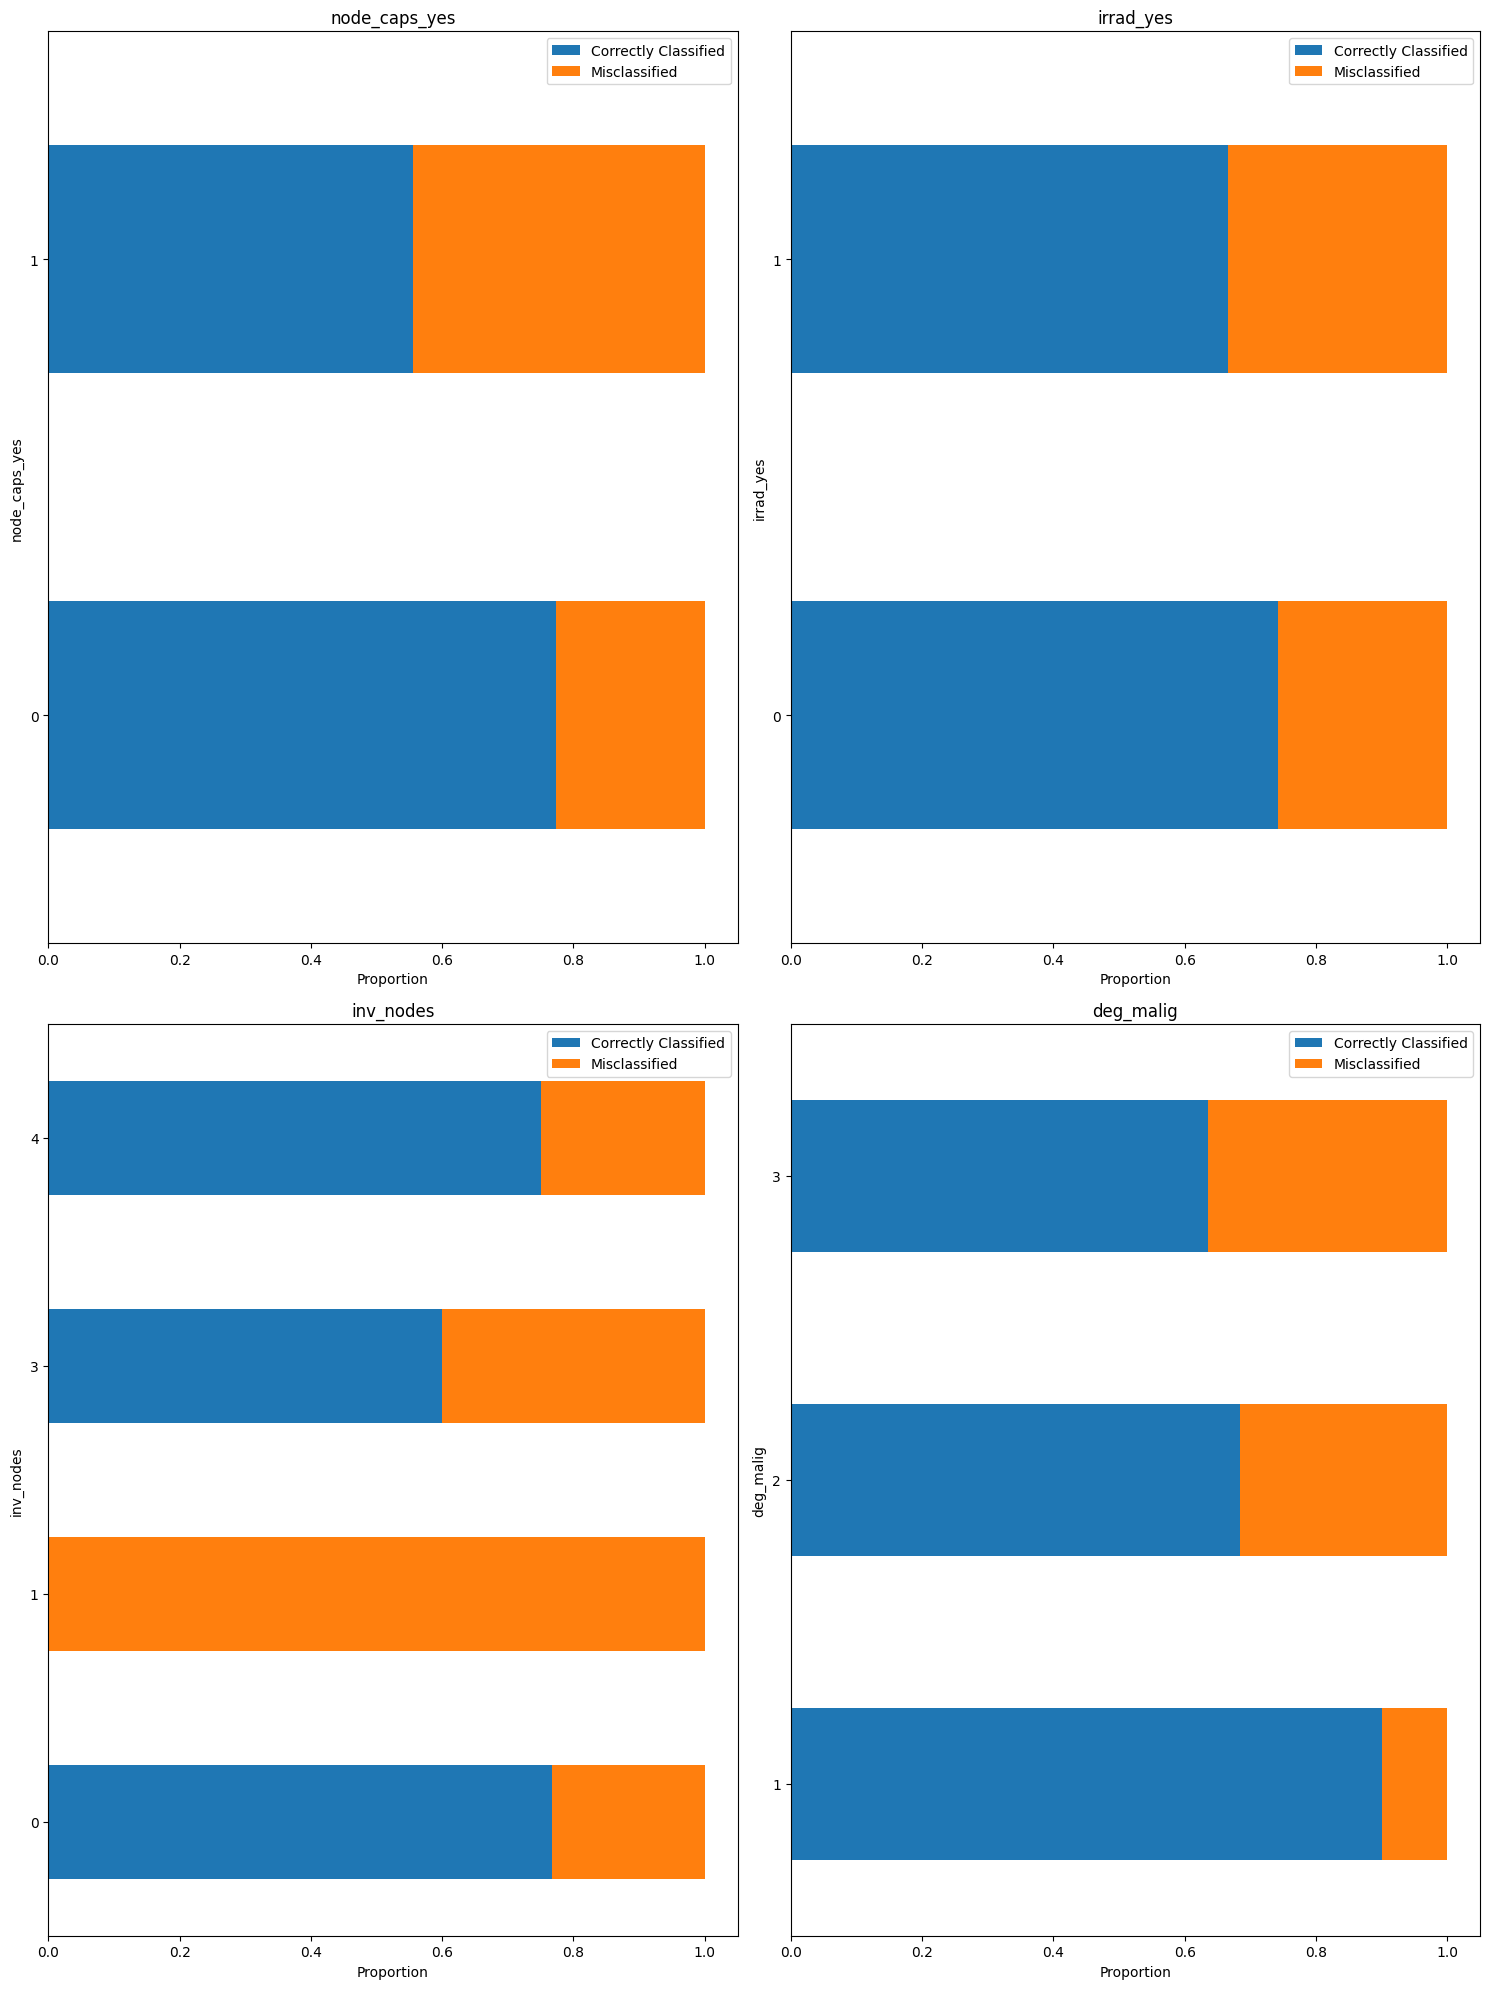

In [26]:
features = X_train_encoded.columns

# Calculate the number of rows and columns for the subplots
n_features = len(features)
ncols = 2
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))

for index, feature in enumerate(features):
    row, col = divmod(index, ncols)
    
    # Calculate the misclassification rate for each feature value
    misclassification_counts = errors_with_labels[feature].value_counts()
    overall_counts = X_eval[feature].value_counts()
    misclassification_rate = misclassification_counts / overall_counts

    # Calculate the classification rate for each feature value
    classification_counts = X_eval[y_eval == y_pred][feature].value_counts()
    classification_rate = classification_counts / overall_counts

    # Create a stacked bar chart
    rate_df = pd.DataFrame({'Correctly Classified': classification_rate, 'Misclassified': misclassification_rate}).fillna(0)
    rate_df.plot(kind='barh', stacked=True, ax=axes[row, col])
    axes[row, col].set_xlabel('Proportion')
    axes[row, col].set_ylabel(feature)
    axes[row, col].set_title(f'{feature}')
    axes[row, col].legend()


# Remove any unused subplots
for i in range(index+1, nrows*ncols):
    row, col = divmod(i, ncols)
    fig.delaxes(axes[row, col])

fig.tight_layout()
plt.show()


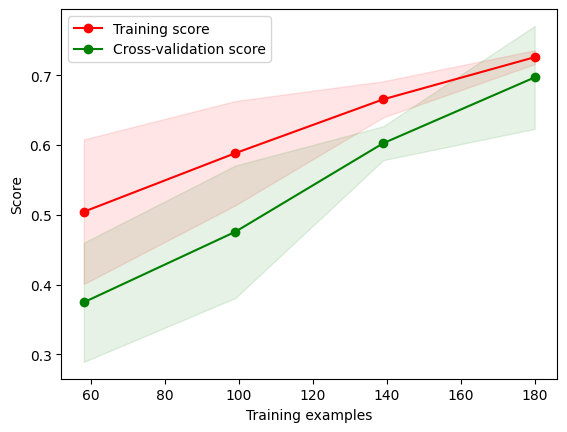

In [27]:
# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(logistic_model_best, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

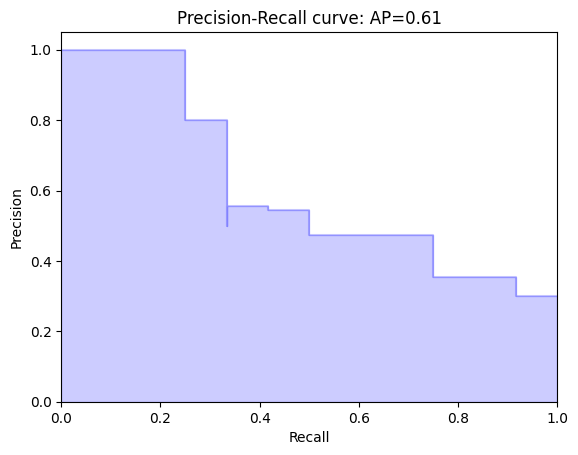

In [28]:
precision, recall, _ = precision_recall_curve(y_eval, y_score)
average_precision = average_precision_score(y_eval, y_score)

# plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

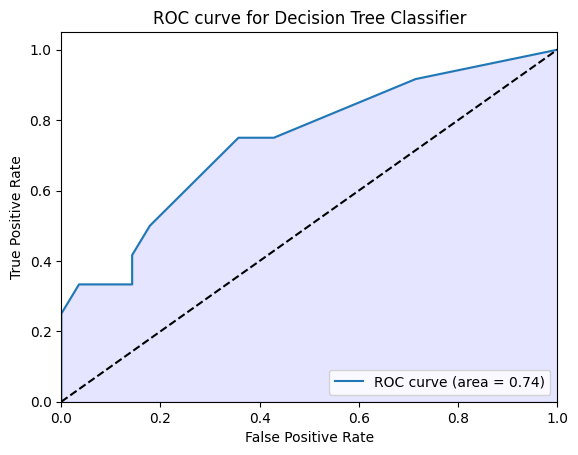

In [29]:
fpr, tpr, _ = roc_curve(y_eval, y_score)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, 0, color='blue', alpha=0.1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


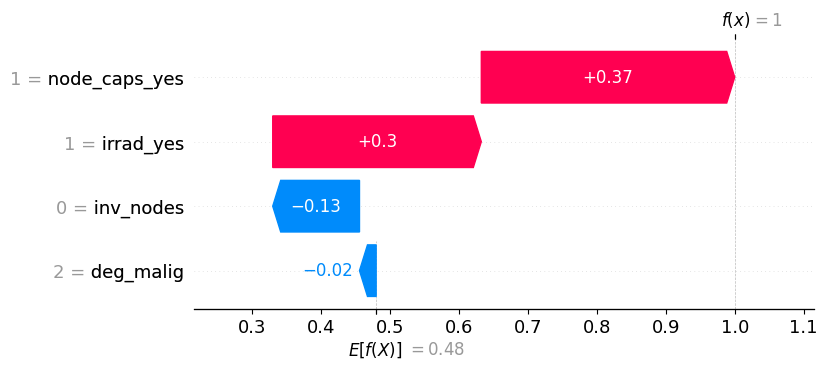

In [30]:
import shap

explainer = shap.Explainer(logistic_model_best.predict, X_train_resampled)
shap_values = explainer(X_eval)

# Plot the SHAP values for a single prediction
shap.plots.waterfall(shap_values[0])

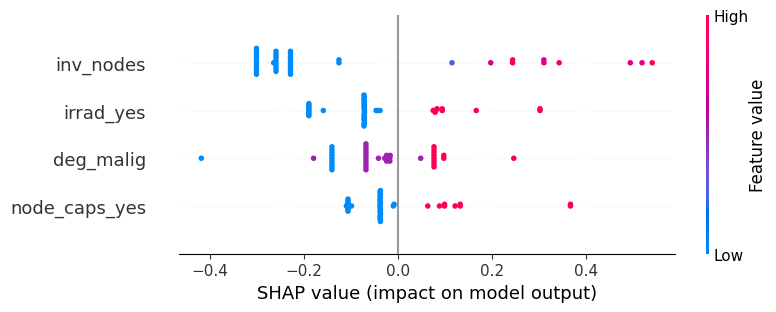

In [31]:
shap.plots.beeswarm(shap_values)

In [32]:
X_train_final, y_train_final = ros.fit_resample(X_train_encoded, y_train_encoded)
logistic_model_best.fit(X_train_final, y_train_final)

LogisticRegression(C=0.1)

In [33]:
def encoding(X_dataset, y_dataset):
    X_dataset = X_dataset[columns_to_keep]
    #X_test_nominal = pd.get_dummies(X_dataset[['node_caps', 'breast_quad', 'irrad']], drop_first=True)
    X_test_nominal = pd.get_dummies(X_dataset[['node_caps', 'irrad']], drop_first=True)
    label_encoder = preprocessing.LabelEncoder()
    #X_test_ordinal = X_dataset[['inv_nodes', 'tumour_size']].copy()
    X_test_ordinal = X_dataset[['inv_nodes']].copy()
    for col in X_test_ordinal.columns:
        X_test_ordinal[col] = label_encoder.fit_transform(X_test_ordinal[col])  
    X_test_numerical = X_dataset[['deg_malig']]                                                                                                
    X_test_encoded = pd.concat([X_test_nominal, X_test_ordinal, X_test_numerical], axis=1) 
    y_test_encoded = y_dataset.replace(['no-recurrence-events', 'recurrence-events'], [0,1]) 
    return X_test_encoded, y_test_encoded           

In [34]:
X_test_encoded, y_test_encoded = encoding(X_test, y_test)

In [35]:
y_pred = logistic_model_best.predict(X_test_encoded)
y_test_score = logistic_model_best.predict_proba(X_test_encoded)[:, 1]


target_names = ['0: no-recurrence-events', '1: recurrence-events']
report = classification_report(y_test_encoded, y_pred, target_names=target_names)
print('Model Performance on Unseen Data')
print(report)

Model Performance on Unseen Data
                         precision    recall  f1-score   support

0: no-recurrence-events       0.78      0.85      0.82        60
   1: recurrence-events       0.57      0.46      0.51        26

               accuracy                           0.73        86
              macro avg       0.68      0.66      0.66        86
           weighted avg       0.72      0.73      0.72        86



In [36]:
# confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print(cm)

[[51  9]
 [14 12]]


In [37]:
errors = X_test_encoded[y_test_encoded != y_pred]
error_labels = y_test_encoded[y_test_encoded != y_pred]
error_predictions = y_pred[y_test_encoded != y_pred]

errors_with_labels = errors.assign(true_label=error_labels, predicted_label=error_predictions)

type_2_err_final = errors_with_labels[(errors_with_labels['true_label'] == 1)
                                & (errors_with_labels['predicted_label'] == 0)]


print('--- False Negatives Final Model ---')
print(display(type_2_err_final))


--- False Negatives Final Model ---


,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
220,0,0,0,3,1,0
216,0,0,0,2,1,0
281,0,0,0,2,1,0
268,0,0,0,3,1,0
217,0,0,0,2,1,0
256,0,1,0,1,1,0
253,0,0,0,3,1,0
269,0,1,0,2,1,0
236,0,0,0,2,1,0
211,0,0,0,2,1,0


None


In [38]:
type_1_err_final = errors_with_labels[(errors_with_labels['true_label'] == 0)
                                & (errors_with_labels['predicted_label'] == 1)]


print('--- False Positives Final Model ---')
print(display(type_1_err_final))


--- False Positives Final Model ---


,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
167,1,1,2,2,0,1
172,1,0,5,2,0,1
131,1,1,4,3,0,1
179,0,1,0,3,0,1
184,0,1,6,3,0,1
129,1,1,6,2,0,1
151,1,0,4,3,0,1
160,0,1,0,3,0,1
130,1,1,6,2,0,1


None


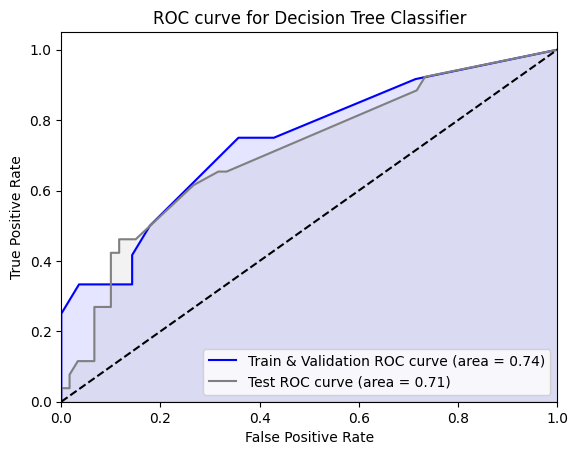

In [39]:
# Calculate ROC curve and AUC for the combined train and validation set
fpr_eval, tpr_eval, _ = roc_curve(y_eval, y_score)
roc_auc_eval = auc(fpr_eval, tpr_eval)

# Calculate ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_test_encoded, y_test_score)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.plot(fpr_eval, tpr_eval, label='Train & Validation ROC curve (area = %0.2f)' % roc_auc_eval, color='blue')
plt.fill_between(fpr_eval, tpr_eval, 0, color='blue', alpha=0.1)

plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test, color='grey')
plt.fill_between(fpr_test, tpr_test, 0, color='grey', alpha=0.1)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


In [40]:
from sklearn import set_config
from IPython.display import display
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier

# Define the columns for OneHotEncoder (nominal) and OrdinalEncoder (ordinal)
nominal_features = ['node_caps', 'breast_quad', 'irrad']  # list of column indices or names for nominal features
ordinal_features = ['inv_nodes', 'tumour_size']  # list of column indices or names for ordinal features
numerical_features = ['deg_malig']

# Create a ColumnTransformer that applies different encoders to different subsets of features
preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), nominal_features),
    ('ordinal', OrdinalEncoder(), ordinal_features),
    ('numerical', 'passthrough', numerical_features)
])

# Enable the diagram display option
set_config(display='diagram')

# Create a pipeline with a preprocessor, a random over sampler, and a K-neighbors classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42, sampling_strategy='minority')),
    ('model', KNeighborsClassifier())
])

# Display the pipeline in the Jupyter notebook
display(pipeline)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['node_caps', 'breast_quad',
                                                   'irrad']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['inv_nodes', 'tumour_size']),
                                                 ('numerical', 'passthrough',
                                                  ['deg_malig'])])),
                ('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('model', KNeighborsClassifier())])